## Importing the Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.optimize import least_squares
from math import isclose

## Cost Function

In [6]:
### Coeficients of the cost functions
C = [
    [-1/7 , 7799/8400, -209/1400, 61/8400],
    [-1/28, 1        , -9/56    , 31/4200],
    [-3/7 , 1        , -43/280  , 31/4200]
]

In [7]:
# Power array
Pow = np.arange(1,25,0.1)

In [8]:
# Cost function of each power plant
Cost_0 = np.array([Pow, Pow**2, Pow**3, Pow**4]).T@(np.array(C[0]).reshape(-1,1))
Cost_1 = np.array([Pow, Pow**2, Pow**3, Pow**4]).T@(np.array(C[1]).reshape(-1,1))
Cost_2 = np.array([Pow, Pow**2, Pow**3, Pow**4]).T@(np.array(C[2]).reshape(-1,1))

## Visualizing the Cost

Text(0, 0.5, 'Cost [$]')

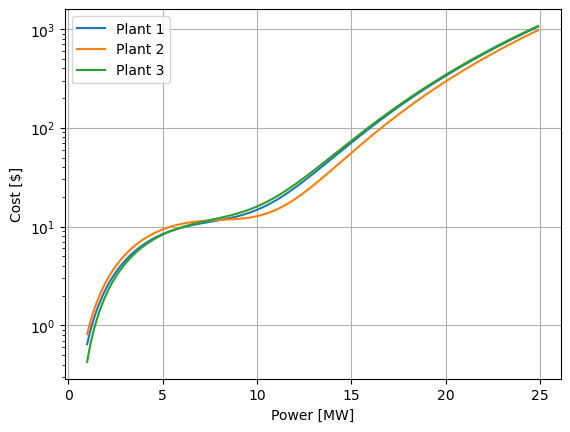

In [10]:
plt.semilogy(Pow, Cost_0, label = 'Plant 1')
plt.semilogy(Pow, Cost_1, label = 'Plant 2')
plt.semilogy(Pow, Cost_2, label = 'Plant 3')
plt.grid()
plt.legend()
plt.xlabel('Power [MW]')
plt.ylabel('Cost [$]')

# Optimization Problem 

Minimize the cost of operation of the 3 power plants, given a power requirement L

#### Augmented Lagrangian

In [12]:
def f(C,P, L, lbd, rho):
         
        func = ((C[0][0]*P[0] + C[0][1]*P[0]**2 + C[0][2]*P[0]**3 + C[0][3]*P[0]**4) +
                (C[1][0]*P[1] + C[1][1]*P[1]**2 + C[1][2]*P[1]**3 + C[1][3]*P[1]**4) +
                (C[2][0]*P[2] + C[2][1]*P[2]**2 + C[2][2]*P[2]**3 + C[2][3]*P[2]**4) -
                lbd*(P[0] + P[1] + P[2] - L) + rho/2*(P[0] + P[1] + P[2] - L)**2  
        )

        return func

#### Derivate of the Augmented Lagrangian

In [15]:
def g(C, P, L, lbd, rho):
    g1 = ((C[0][0] + 2*C[0][1]*P[0] + 3*C[0][2]*P[0]**2 + 4*C[0][3]*P[0]**3) - lbd + rho*(P[0] + P[1] + P[2] - L))
    g2 = ((C[1][0] + 2*C[1][1]*P[1] + 3*C[1][2]*P[1]**2 + 4*C[1][3]*P[1]**3) - lbd + rho*(P[0] + P[1] + P[2] - L))
    g3 = ((C[2][0] + 2*C[2][1]*P[2] + 3*C[2][2]*P[2]**2 + 4*C[2][3]*P[2]**3) - lbd + rho*(P[0] + P[1] + P[2] - L))
    return np.array([g1, g2, g3])


#### Hessian of the Augmented Lagrangian

In [16]:
def H(C,P, rho):

    h1 = ((2*C[0][1] + 6*C[0][2]*P[0] + 12*C[0][3]*P[0]**2) + rho)
    h2 = ((2*C[1][1] + 6*C[1][2]*P[1] + 12*C[1][3]*P[1]**2) + rho)
    h3 = ((2*C[2][1] + 6*C[2][2]*P[2] + 12*C[2][3]*P[2]**2) + rho)

    Hes = [
        [h1  , rho , rho],
        [rho , h2  , rho],
        [rho , rho , h3 ]
    ]

    return Hes

#### Auxiliar functions

In [18]:
def m(f0, g0, B0, p0):

    return f0 + g0@p0.reshape(-1,1) + p0@B0@p0.reshape(-1,1)

In [19]:
def c(P,L):
    return sum(P) -L

In [20]:
def const(p0):
    return L - np.sum(p0) 

In [21]:
def f_scipy(P):
        func = ((C[0][0]*P[0] + C[0][1]*P[0]**2 + C[0][2]*P[0]**3 + C[0][3]*P[0]**4) +
                (C[1][0]*P[1] + C[1][1]*P[1]**2 + C[1][2]*P[1]**3 + C[1][3]*P[1]**4) +
                (C[2][0]*P[2] + C[2][1]*P[2]**2 + C[2][2]*P[2]**3 + C[2][3]*P[2]**4) - 
                lbd*(P[0] + P[1] + P[2] - L) + rho/2*(P[0] + P[1] + P[2] - L)**2  
        )
        return func

In [22]:
def T(Tau, Data):
    p_u, p_b, Delta = Data  
    vec = p_u + (Tau-1)*(p_b-p_u)
    return(np.linalg.norm(vec)**2 - Delta**2)

In [23]:
def constraint(p0):
    return Delta - np.linalg.norm(p0) 

In [24]:
def m_scipy(p0, Data):
    f_0, g_0, B_0 = Data  
    return f_0 + g_0@p0.reshape(-1,1) + p0@B_0@p0.reshape(-1,1)

#### Confidence region

In [26]:
def conf_reg(C,f,g,H,lbd, rho_lag, X_0):
    L = 25

    Delta_max = 20
    it_max = 50

    #X_0 = [L/3, L/3, L/3]
    it = 0
    X = X_0
    global Delta

    met = 'Exact'
    Delta = 1
    eta = 0

    g_0 = g(C, X, L, lbd, rho_lag)
    
    p  =[1,1,1]

    while it < it_max and np.linalg.norm(g_0) > 10**-5 and np.linalg.norm(p) > 1.e-12:

        f_0 = f(C, X, L, lbd, rho_lag)
        g_0 = g(C, X, L, lbd, rho_lag)
        B_0 = H(C, X, rho_lag)


        if met == 'DogLeg':
            p_b = - np.dot(np.linalg.norm(B_0),g_0) 
            p_u = - np.dot(g_0,g_0)/np.dot(np.dot(g_0, B_0),g_0)*g_0 

            if np.linalg.norm(p_b) <= Delta:
                p = p_b
        
            else:
                tau = fsolve(T,args = np.array([p_u, p_b, Delta]), x0 = [1.5], maxfev = 10000000)
                p = p_u + (tau-1)*(p_b-p_u)

        elif met == 'Exact':
            p = minimize(m_scipy,  args = [f_0, g_0, B_0 ],  x0 = [1, 1, 1],  method = 'SLSQP', constraints={"fun": constraint, "type": "ineq"}).x

        rho_conf = (f_0 - f(C, X + p, L, lbd, rho_lag))/(f_0 - m(f_0, g_0, B_0, p))
        

        if rho_conf < 0.25:
            Delta = 0.25*Delta
            
        elif rho_conf > 0.75 and isclose(np.linalg.norm(p), Delta, rel_tol =1e-1):
            Delta = np.minimum(2*Delta, Delta_max)

        

        if rho_conf > eta:
            X = X + p

        it =  it + 1

    return X, it


## Case 1

In [30]:
# Power requirement
L = 25

# Lagrangian coeficient
lbd = 1
global lbd

# rho
rho = 1/8
global rho

# Initial guess
X_0 = [L/3, L/3, L/3]

#Constraints
eta_s = 10**-5
omega_s = 10**-5
it_max = 50
eta = 1/(rho)**0.1

P_n = X_0
#Empty arrays
p_array = []
ite_array = []
lambda_array = []
rho_array = []
eta_array = []
omega_array = []
g_array = []


it = 0
while it < it_max:

    P_a = P_n
    P_n, ite = conf_reg(C, f, g, H, lbd, rho, P_n,)
    
    error_c = np.linalg.norm(c(P_n,L))
    error_g = np.linalg.norm(g(C,P_n,L, lbd, rho))
    error_p = np.linalg.norm(np.abs(P_n - P_a))

    if error_c <= eta:
        if error_c <=eta_s and error_g <= omega_s: #or error_p < 10**-1:
            break
        lbd = lbd - rho*c(P_n,L)
        eta = eta/rho**0.9
        omega = omega/rho
    else:
        rho = 10*rho
        eta = 1/rho**0.1
        omega = 1/rho
    print("Power in iteraction " + str(it) + " is " + str(P_n) + ", found in" + str(ite) + " iteractions with lambda = " + str(lbd))
    
    p_array.append(P_n)
    ite_array.append(ite)
    lambda_array.append(lbd)
    rho_array.append(rho)
    eta_array.append(eta)
    omega_array.append(omega)
    g_array.append(error_g)

    it = it+1

Power in iteraction 0 is [ 9.08148971 10.20533597  1.38982966], found in25 iteractions with lambda = 1
Power in iteraction 1 is [ 9.59456801 10.56932882  3.95498354], found in21 iteractions with lambda = 2.1013995291204104
Power in iteraction 2 is [8.47594275 9.85700568 7.4610807 ], found in50 iteractions with lambda = 1.108863114324791
Power in iteraction 3 is [ 9.54386485 10.53126085  4.18217215], found in21 iteractions with lambda = 1.108863114324791
Power in iteraction 4 is [ 8.8070861  10.03445301  6.14187956], found in22 iteractions with lambda = 1.316129649670298
Power in iteraction 5 is [ 8.78186095 10.01977316  6.19981789], found in17 iteractions with lambda = 1.2979796877730578
Power in iteraction 6 is [ 8.78402409 10.02102456  6.19482846], found in13 iteractions with lambda = 1.299515830039292
Power in iteraction 7 is [ 8.78384192 10.02091882  6.19524938], found in10 iteractions with lambda = 1.299389304607649


In [31]:
iter = np.arange(1,len(ite_array)+1)

In [32]:
iter

array([1, 2, 3, 4, 5, 6, 7, 8])

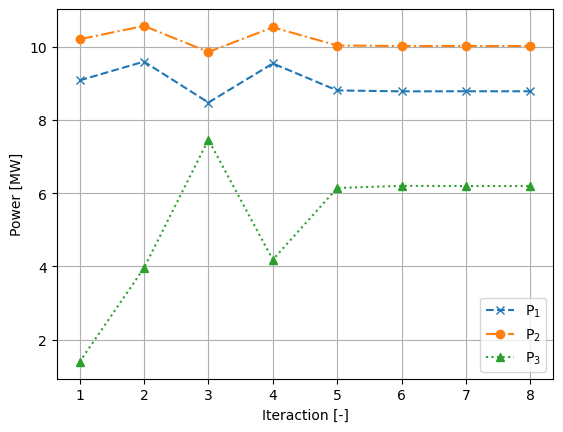

In [34]:
plt.plot(iter,np.array(p_array).T[0], 'x--', label='P$_\mathrm{1}$')
plt.plot(iter, np.array(p_array).T[1], 'o-.', label='P$_\mathrm{2}$')
plt.plot(iter, np.array(p_array).T[2], '^:', label='P$_\mathrm{3}$')
plt.legend()
plt.grid()
plt.xlabel('Iteraction [-]')
plt.ylabel('Power [MW]')
plt.savefig('Plots/Case1_Variables.pdf',
            format='pdf', bbox_inches='tight')


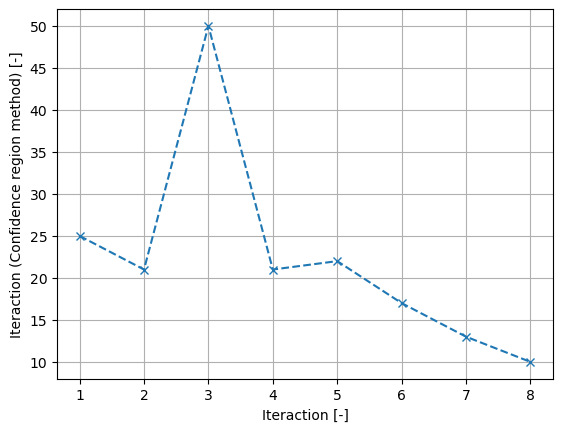

In [35]:
plt.plot(iter, ite_array, 'x--')
plt.grid()
plt.xlabel('Iteraction [-]')
plt.ylabel('Iteraction (Confidence region method) [-]')
plt.savefig('Plots/Case1_Ite.pdf',
            format='pdf', bbox_inches='tight')

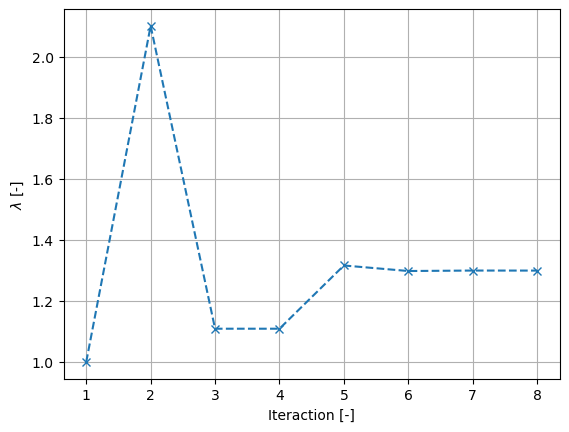

In [36]:
plt.plot(iter, lambda_array, 'x--')
plt.grid()
plt.ylabel('$\lambda$ [-]')
plt.xlabel('Iteraction [-]')
plt.savefig('Plots/Case1_Lambda.pdf',
            format='pdf', bbox_inches='tight')


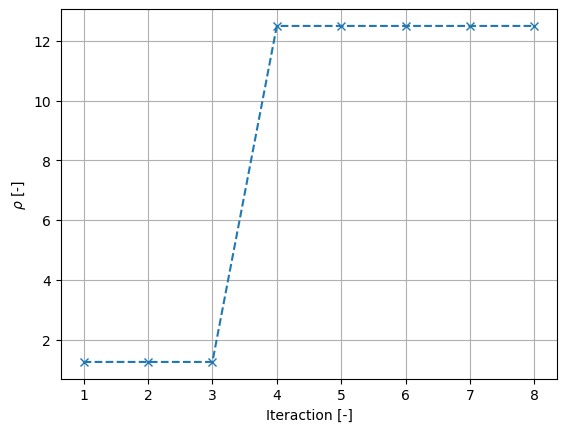

In [37]:
plt.plot(iter, rho_array, 'x--')
plt.grid()
plt.ylabel(r'$\rho$ [-]')
plt.xlabel('Iteraction [-]')
plt.savefig('Plots/Case1_rho.pdf',
            format='pdf', bbox_inches='tight')


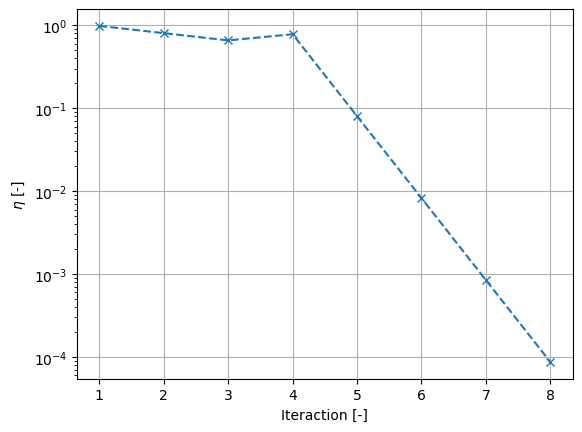

In [38]:
plt.semilogy(iter, eta_array, 'x--')
plt.grid()
plt.ylabel(r'$\eta$ [-]')
plt.xlabel('Iteraction [-]')
plt.savefig('Plots/Case1_eta.pdf',
            format='pdf', bbox_inches='tight')


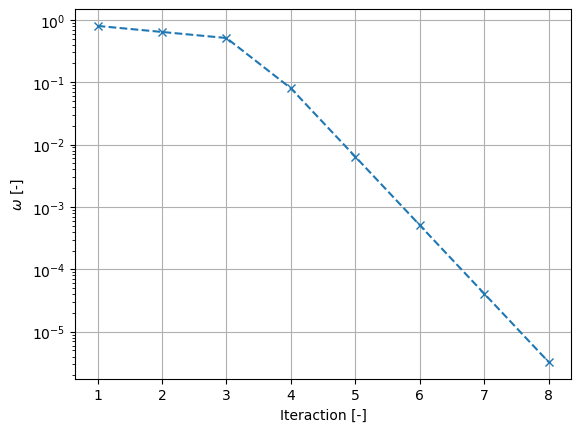

In [39]:
plt.semilogy(iter, omega_array, 'x--')
plt.grid()
plt.ylabel(r'$\omega$ [-]')
plt.xlabel('Iteraction [-]')
plt.savefig('Plots/Case1_omega.pdf',
            format='pdf', bbox_inches='tight')
